In [2]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
# Import SQLAlchemy `automap` and other dependencies here
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
import datetime as dt

In [6]:
# Reflect tables from sqlite database

engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# View classes

Base.classes.keys()

['measurement', 'station']

In [8]:
# Save table references

Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create session
session = Session(engine)

In [10]:
# Display first row of Measurement table (want columnn names)

first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe37907ba50>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1}

In [11]:
# Find last day in records to compute date a year from last day

last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_day = last_day[0]
format_str = '%Y-%m-%d'
last_day = dt.datetime.strptime(last_day, format_str)
year_ago = last_day - dt.timedelta(days=365)
year_ago = year_ago.strftime("%Y-%m-%d")
print(year_ago)

2016-08-23


In [13]:
# Find date and precipitation scores from Measurement within last 12 months
# Save sorted & indexed data to Pandas DataFrame

precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

precipitation_df = pd.DataFrame(precip)
precipitation_df.dropna(inplace=True)

precipitation_df = precipitation_df.set_index("date")
precipitation_df = precipitation_df.sort_values("date")
precipitation_df

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


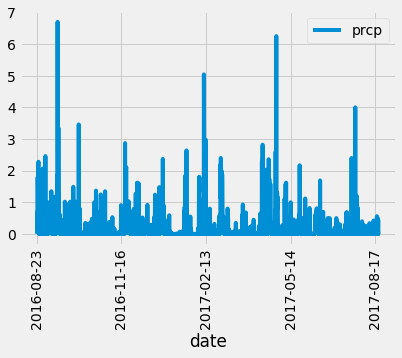

In [14]:
#Plot results

precipitation_df.plot(rot=90)

In [15]:
# Summary Statistics 

precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Display first row of Station table (want columnn names)

first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe3792cc0d0>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [17]:
# Count number of stations in dataset

station_count = session.query(Station).count()
station_count

9

In [18]:
# Query Measurement dataset for most-used stations

station_count = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Show which station had the most observances

max_observances = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
max_observances[0]

'USC00519281'

In [30]:
# Calculate lowest temperature recorded at most-observed station in the last 12 months

lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.date > year_ago).\
    filter(Measurement.station == max_observances[0]).all()
lowest_temp = round(lowest_temp[0][0],2)
print(f"Lowest Temp: {lowest_temp}")

Lowest Temp: 59.0


In [23]:
# Calculate highest temperature recorded at most-observed station in the last 12 months

highest_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.date > year_ago).\
    filter(Measurement.station == max_observances[0]).all()
highest_temp = round(highest_temp[0][0],2)
print(f"Highest Temp: {highest_temp}")

Highest Temp: 83.0


In [24]:
# Calculate average temperature at most-observed station in the last 12 months

avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.date > year_ago).\
    filter(Measurement.station == max_observances[0]).all()
avg_temp = round(avg_temp[0][0],2)
print(f"Avg Temp: {avg_temp}")

Avg Temp: 73.1


In [25]:
# Query Measurement dataset for all dates and temps recorded at the most-observed station in the last 12 months

temp = session.query(Measurement).\
    filter(Measurement.date > year_ago).\
    filter(Measurement.station == max_observances[0]).all()

temps = []
dates = []

for t in temp:
    temps.append(t.tobs)
    dates.append(t.date)

In [26]:
# Create dataframe

temperatures = {"date":dates, "temp":temps}
temp_df = pd.DataFrame(temperatures)

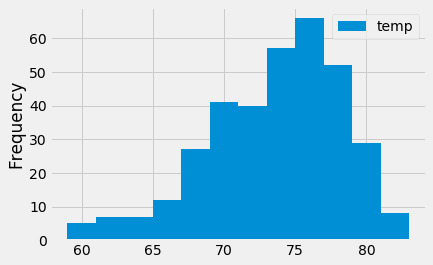

In [27]:
# Plot temperature histogram

temp_hist = temp_df.plot.hist(by=["temp"], bins=12)

In [57]:
# Determine years in dataset

years = [2016, 2015, 2014, 2013, 2012, 2011, 2010]

for year in years:
    search_date = f"{year}-01-01"
    days = session.query(Measurement.date).\
        filter(Measurement.date<search_date).\
        order_by(Measurement.date.desc())
    print(days.first())

('2015-12-31',)
('2014-12-31',)
('2013-12-31',)
('2012-12-31',)
('2011-12-31',)
('2010-12-31',)
None


In [141]:
# Query for average temperatures in June and save to list

june_temps = []

for year in years:
    search_begin = f"{year}-06-01"
    search_end = f"{year}-06-30"
    avg_temp = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.date >= search_begin).\
        filter(Measurement.date <= search_end)
    avg_temp = round(avg_temp[0][0],2)
    june_temps.append(avg_temp)

    print(f"June {year} Avg Temp: {avg_temp}")

June 2016 Avg Temp: 75.18
June 2015 Avg Temp: 74.99
June 2014 Avg Temp: 75.03
June 2013 Avg Temp: 74.6
June 2012 Avg Temp: 74.0
June 2011 Avg Temp: 73.94
June 2010 Avg Temp: 74.93


In [59]:
# Query for average temperatures in December and save to list

dec_temps = []

for year in years:
    try:
        search_begin = f"{year}-12-01"
        search_end = f"{year}-12-31"
        avg_temp = session.query(func.avg(Measurement.tobs)).\
            filter(Measurement.date >= search_begin).\
            filter(Measurement.date <= search_end)
        avg_temp = round(avg_temp[0][0],2)
        dec_temps.append(avg_temp)
        print(f"December {year} Avg Temp: {avg_temp}")
    except:
        dec_temps.append(None)
        print(f"No temperature data available for December {year}")

December 2016 Avg Temp: 71.13
December 2015 Avg Temp: 73.42
December 2014 Avg Temp: 69.9
December 2013 Avg Temp: 71.09
December 2012 Avg Temp: 71.19
December 2011 Avg Temp: 70.82
December 2010 Avg Temp: 70.21


In [61]:
# Use paired t-test to determine if means are statistically significant

# Reason: For this dataset, use paired t-test because all station temperature recordings were taken twice, 
# rather than different stations being used for each month

from scipy import stats

stats.ttest_rel(june_temps, dec_temps)

Ttest_relResult(statistic=7.787861558329485, pvalue=0.00023611492206364811)

In [64]:
# Calculate min, max, and avg temperatures during trip duration

trip_start = '2017-07-08'
trip_end = '2017-07-22'


def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


# function usage example
temp_result = calc_temps(trip_start, trip_end)
print(temp_result)

[(69.0, 78.28865979381443, 83.0)]


In [112]:
# Assign result to separate variables

max_temp = temp_result[0][2]
min_temp = temp_result[0][0]

temp_dict = {"avg": [temp_result[0][1]]}

In [113]:
# Make Pandas DataFrame for average temperature

temp_df = pd.DataFrame(temp_dict)
temp_df

,avg
0,78.28866


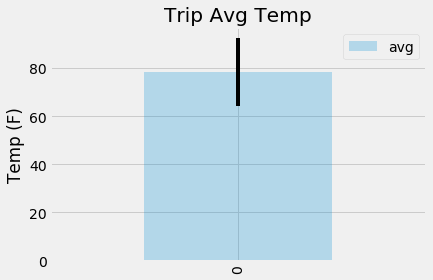

In [131]:
# Plot average temperature for trip

error = max_temp-min_temp

temp_df.plot(kind="bar", alpha=.25, yerr=error)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim = (0,100)

plt.show()

In [146]:
# Return precipitation numbers by station for trip duration

trip_precip = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

trip_precip

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  9.91),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.7000000000000002),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.9500000000000002),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.88),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.44),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.25),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

In [158]:
# Create list of %m-%d values for trip duration

trip_days = []

for i in range(15):
    if (i+8)<10:
        trip_days.append(f"07-0{i+8}")
    else:
        trip_days.append((f"07-{i+8}"))

In [160]:
# Calculate daily normals for trip duration

trip_normals = []

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
for day in trip_days:
    normals = daily_normals(day)
    trip_normals.append(normals)

In [176]:
# Create separate lists for min, max, and average daily normals

min_temps = []
avg_temps = []
max_temps = []

for trip in trip_normals:
    min_temps.append(trip[0][0])
    avg_temps.append(trip[0][1])
    max_temps.append(trip[0][2])

In [177]:
# Create list of %y-%m-%d values for trip duration

trip_dates = []

for i in range(15):
    if (i+8)<10:
        trip_dates.append(f"2018-07-0{i+8}")
    else:
        trip_dates.append((f"2018-07-{i+8}"))

In [181]:
# Create Pandas DataFrame for daily normals

trip_dict = {"date":trip_dates, "min":min_temps, "avg":avg_temps, "max":max_temps}

trip_df = pd.DataFrame(trip_dict)
trip_df = trip_df.set_index("date")
trip_df

,min,avg,max
date,,,
2018-07-08,69.0,76.083333,83.0
2018-07-09,68.0,76.192982,83.0
2018-07-10,68.0,75.620690,82.0
2018-07-11,70.0,75.789474,81.0
2018-07-12,67.0,75.964912,82.0
2018-07-13,69.0,76.189655,81.0
2018-07-14,61.0,76.228070,82.0
2018-07-15,68.0,76.254237,82.0
2018-07-16,70.0,76.344828,83.0


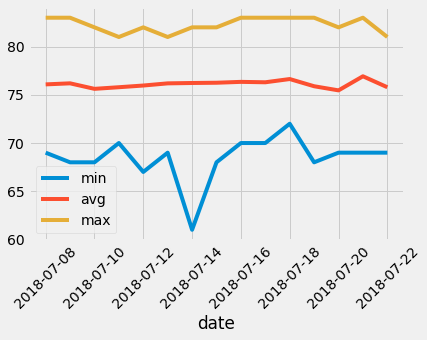

In [182]:
# Plot min, max, and avg daily normals for trip duration

trip_df.plot(stacked=False, rot=45)